# 1. Introduction
## 1.1. Business Problem

In this capstone project we will compare neighborhoods of the two cities and determine how similar or dissimilar they are. The given model can be applied for comparison with other cities as well.

## 1.2. Target Audience
The target audience of this report would be anyone who wants to move to a similar neighborhood in another city or wants to relocate (open new location of) business (bar, bakery, bookstore etc.)  in  a similar neighborhood in another city.
 
 
# 2. Data
## 2.1.1 Los Angeles Crime Data

In [1175]:
#importing libraries
import config
import utils
import requests
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy 
from scipy import stats

matplotlib.style.use("fivethirtyeight")
%matplotlib inline

In [797]:
# https://xtown.la/2019/08/08/so-far-la-crime-in-2019-is-dipping/
la_crimes_df = pd.read_csv('data/la_crimes.csv')
la_crimes_df.head()

,Neighborhood,TotalCrime
0,Westwood,1255
1,Venice,4591
2,Westchester,4622
3,Financial District,3200
4,South Park,3227


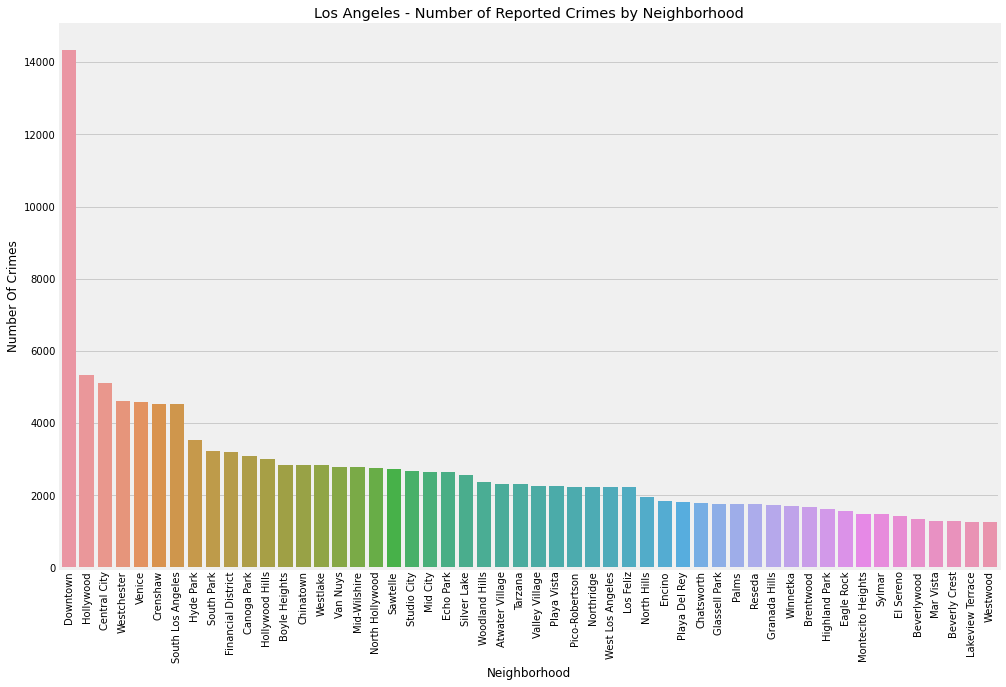

In [798]:
utils.plot_barchart(la_crimes_df, 'Neighborhood', 'TotalCrime', ylabel='Number Of Crimes', title='Los Angeles - Number of Reported Crimes by Neighborhood')

## 2.1.2 Los Angeles  Average Rent By Neighborhood

In [799]:
la_neighborhoods = pd.read_csv('data/la_neighborhoods_average_rent.csv', sep=':')

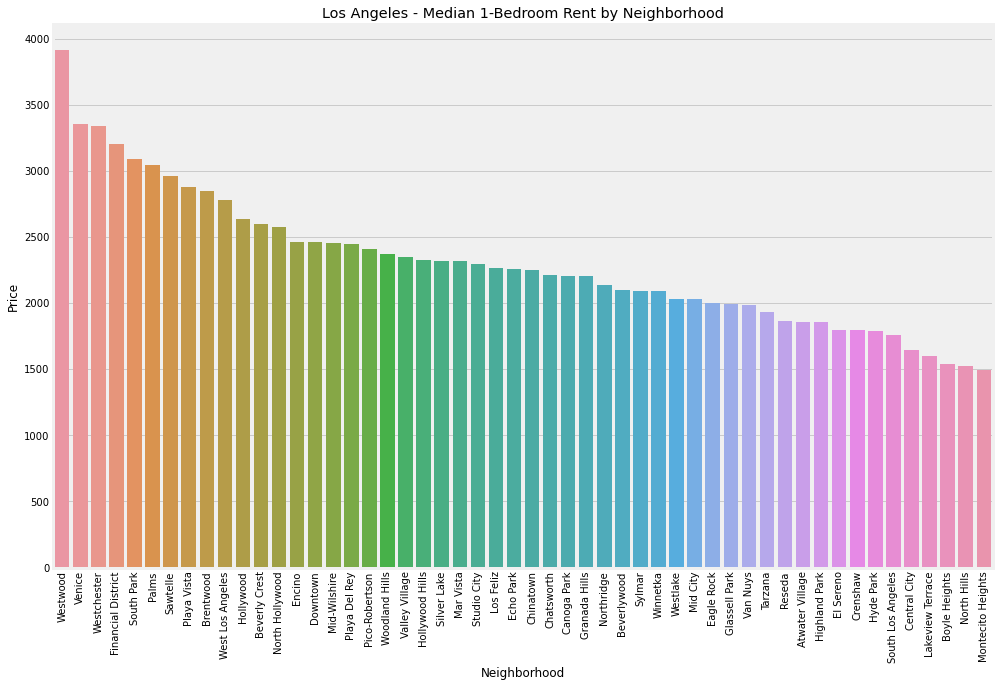

In [800]:
utils.plot_barchart(la_neighborhoods, 'Neighborhood', 'RentPrice', ylabel='Price', title='Los Angeles - Median 1-Bedroom Rent by Neighborhood')

In [801]:
# fitting crime data to Los Angeles average rent data frame
# key -> names, replacing names with key value
change_name_dict = {
    'South Los Angeles': ['Willowbrook', 'University Park', 'Baldwin Hills/Crenshaw', 'Leimert Park', 'Westmont', 'Central-Alameda'],
    'Lakeview Terrace' : ['Lake View Terrace'],
    'Central City':['Paramount'],
    'Crenshaw':['Baldwin Hills/Crenshaw'],
    'Mid City':['Mid-City'],
    'Playa Del Ray':['Playa del Rey']
}

la_crimes_df['Neighborhood'] = la_crimes_df['Neighborhood'].apply(utils.change_neighborhood_name, args=(change_name_dict,))

la_crimes_df = la_crimes_df.groupby('Neighborhood').sum()

In [802]:
# merging crime data with average rent data
la_neighborhoods = la_neighborhoods.merge(la_crimes_df, on='Neighborhood', how='left')

In [803]:
la_neighborhoods.fillna(0, inplace=True)

In [804]:
cordinatets_df = pd.read_csv('data/la_neighborhoods_coordinates.csv')

In [805]:
la_neighborhoods = la_neighborhoods.merge(cordinatets_df, on='Neighborhood', how='left')

In [1105]:
# Data normalization, ignoring spikes data
la_neighborhoods['CrimeRate'] = la_neighborhoods['TotalCrime'] / la_neighborhoods['TotalCrime'].nlargest(2).iloc[1]
la_neighborhoods['RentRate'] = la_neighborhoods['RentPrice'] / la_neighborhoods['RentPrice'].nlargest(2).iloc[1]
la_neighborhoods.head()

,Neighborhood,RentPrice,TotalCrime,Latitude,Longitude,CrimeRate,RentRate
0,Westwood,3915,1255,34.056121,-118.430635,0.235239,1.166567
1,Venice,3356,4591,33.995044,-118.466887,0.860544,1.000000
2,Westchester,3338,4622,33.959735,-118.400632,0.866354,0.994636
3,Financial District,3206,3200,34.045762,-118.259305,0.599813,0.955304
4,South Park,3090,3227,33.995938,-118.269761,0.604873,0.920739


In [1102]:
la_neighborhoods['TotalCrime'] 

5335

Los Angeles Neighborhoods Map


In [106]:
address = 'Los Angeles, California'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
la_latitude = location.latitude
la_longitude = location.longitude
print(f"{address} : {la_latitude, la_longitude}")
la_map = utils.draw_neigborhoods_map((la_latitude, la_longitude), la_neighborhoods)
la_map

Los Angeles, California : (34.0536909, -118.2427666)


## 2.1.3 Los Angeles Foursquare Data

Explore Neighborhoods (radius 750 meters)

In [316]:
la_venues = utils.getNearbyVenues(names=la_neighborhoods['Neighborhood'],
                                   latitudes=la_neighborhoods['Latitude'],
                                   longitudes=la_neighborhoods['Longitude'],
                                   radius=750
                                  )

Westwood
Venice
Westchester
Financial District
South Park
Palms
Sawtelle
Playa Vista
Brentwood
West Los Angeles
Hollywood
North Hollywood
Encino
Downtown
Mid-Wilshire
Playa Del Rey
Pico-Robertson
Woodland Hills
Valley Village
Hollywood Hills
Silver Lake
Mar Vista
Studio City
Los Feliz
Echo Park
Chinatown
Chatsworth
Canoga Park
Granada Hills
Northridge
Sylmar
Winnetka
Westlake
Mid City
Eagle Rock
Glassell Park
Van Nuys
Tarzana
Reseda
Atwater Village
Highland Park
El Sereno
Crenshaw
Hyde Park
South Los Angeles
Central City
Lakeview Terrace
Boyle Heights
North Hills
Montecito Heights
Beverly Crest
Beverlywood


In [317]:
top_10_la_venues = la_venues['Venue Category'].value_counts().head(10)

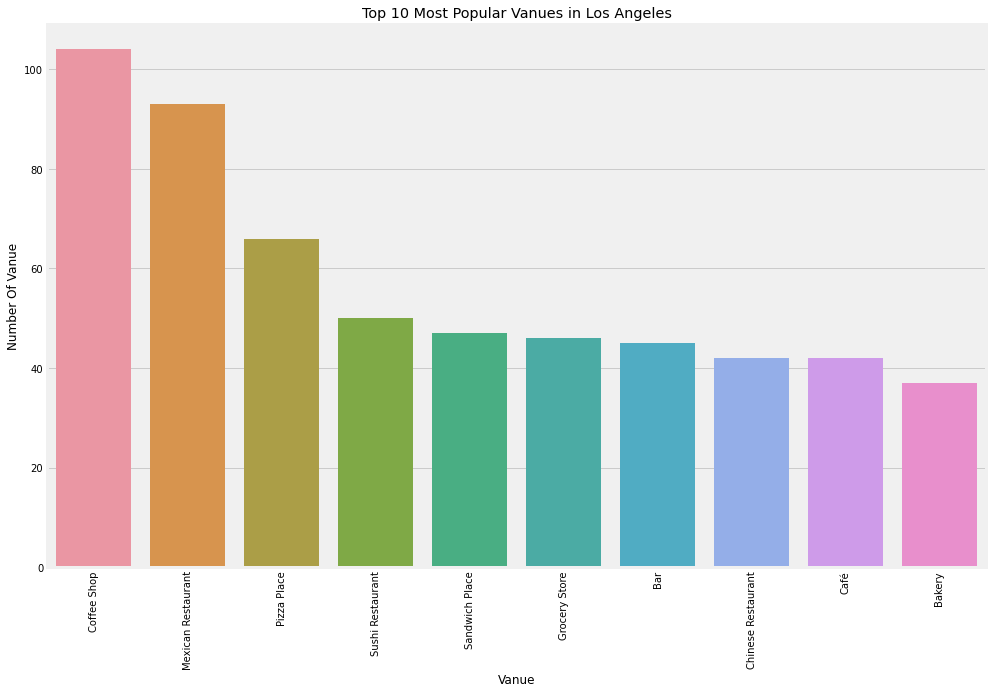

In [318]:
utils.plot_barchart(pd.DataFrame(top_10_la_venues).reset_index(), 'index', 'Venue Category', xlabel='Vanue', ylabel='Number Of Vanue', title='Top 10 Most Popular Vanues in Los Angeles')

## 2.2.1 San Francisco Crime Data

In [807]:
# https://data.sfgov.org/api/views/wg3w-h783/rows.csv
sf_crimes_df = pd.read_csv('data/sf_crimes.csv')

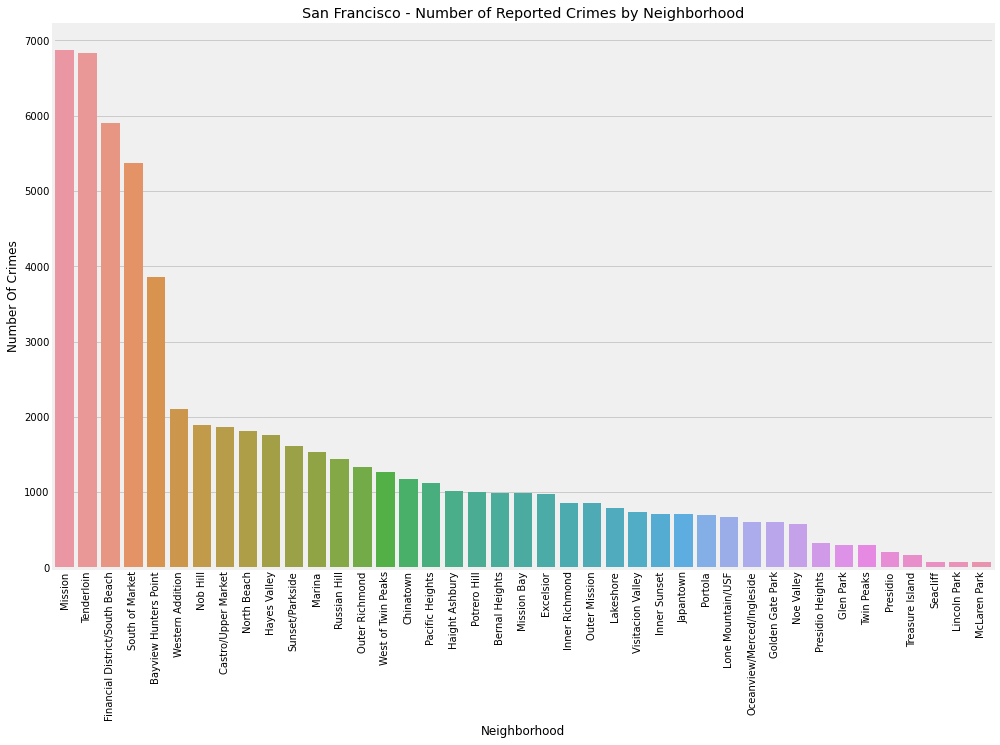

In [808]:
utils.plot_barchart(sf_crimes_df, 'Neighborhood', 'TotalCrime', ylabel='Number Of Crimes', title='San Francisco - Number of Reported Crimes by Neighborhood')

In [809]:
sf_cordinatets_df = pd.read_csv('data/sf_neighborhoods_coordinates.csv')

In [810]:
set(sf_cordinatets_df['Neighborhood']) - set(sf_crimes_df['Neighborhood'])

{'South Of Market'}

In [811]:
set(sf_crimes_df['Neighborhood']) - set(sf_cordinatets_df['Neighborhood']) 

{'Golden Gate Park',
 'Lincoln Park',
 'McLaren Park',
 'South of Market',
 'Treasure Island'}

In [813]:
# fitting crime data to Los Angeles average rent data frame
# change_name_dict = {
#   'West Of Twin Peaks' : ['West of Twin Peaks'],
#   'Downtown' : ['Tenderloin', 'Hayes Valley'],
#   'Haight-Ashbury': ['Haight Ashbury'],
#   'South Of Market':['South of Market'],
#   'Bayview':['Bayview Hunters Point'],
#   'Castro-Upper Market': ['Castro/Upper Market'],
#   'Financial District': ['Financial District/South Beach']   
# }

# replacing 'South of Market' with 'South Of Market'
change_name_dict = {
  'South Of Market':['South of Market'], 
}

sf_crimes_df['Neighborhood'] = sf_crimes_df['Neighborhood'].apply(utils.change_neighborhood_name, args=(change_name_dict,))

sf_crimes_df = sf_crimes_df.groupby('Neighborhood').sum().reset_index()
sf_neighborhoods = sf_cordinatets_df.merge(sf_crimes_df, on='Neighborhood', how='left')
sf_neighborhoods

,Neighborhood,Latitude,Longitude,TotalCrime
0,Bayview Hunters Point,37.730769,-122.382009,3858
1,Bernal Heights,37.740512,-122.416067,996
2,Castro/Upper Market,37.762519,-122.436733,1864
3,Chinatown,37.797113,-122.406529,1173
4,Excelsior,37.720120,-122.434370,983
5,Financial District/South Beach,37.792437,-122.396564,5906
6,Glen Park,37.739886,-122.437455,300
7,Inner Richmond,37.781425,-122.465499,862
8,Haight Ashbury,37.767617,-122.442736,1017
9,Hayes Valley,37.774691,-122.430372,1765


## 2.2.2 San Francisco Average Rent By Neighborhood

In [814]:
sf_averagerent_df = pd.read_csv('data/sf_neighborhoods_average_rent.csv')

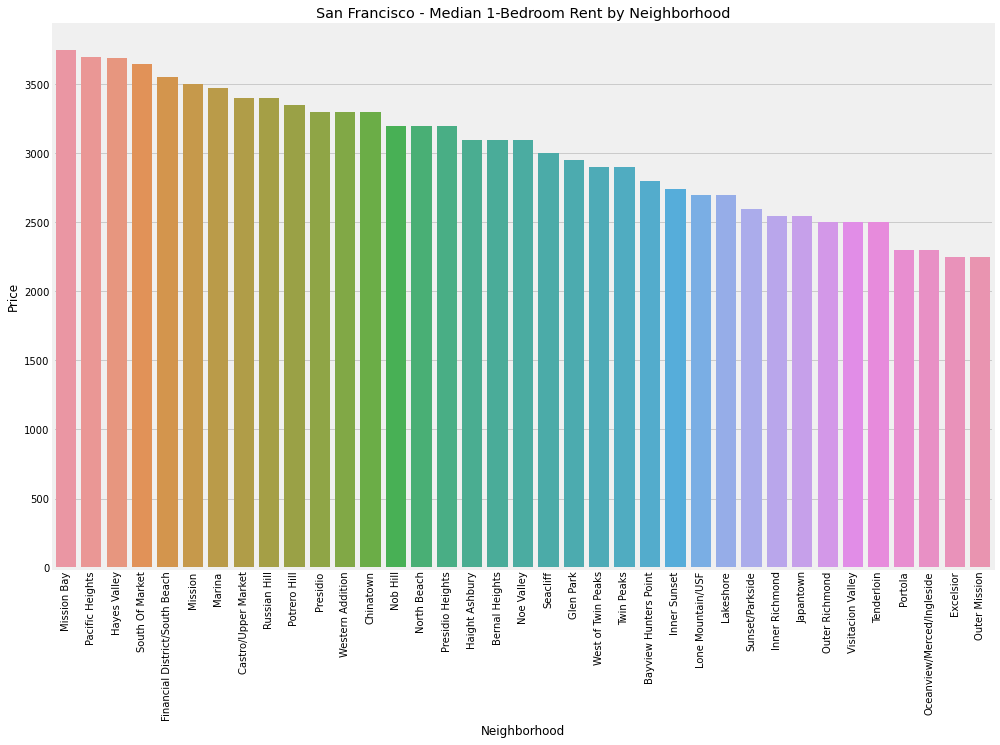

In [815]:
utils.plot_barchart(sf_averagerent_df , 'Neighborhood', 'RentPrice', ylabel='Price', title='San Francisco - Median 1-Bedroom Rent by Neighborhood')

In [817]:
sf_neighborhoods = sf_neighborhoods.merge(sf_averagerent_df, on='Neighborhood', how='left')

In [1181]:
# Data normalization
#sf_neighborhoods['CrimeRate'] = stats.zscore(sf_neighborhoods['TotalCrime'])
sf_neighborhoods['CrimeRate'] = sf_neighborhoods['TotalCrime'] / sf_neighborhoods['TotalCrime'].nlargest(6).iloc[5]
sf_neighborhoods['RentRate'] = sf_neighborhoods['RentPrice'] / sf_neighborhoods['RentPrice'].max()
sf_neighborhoods

,Neighborhood,Latitude,Longitude,TotalCrime,RentPrice,CrimeRate,RentRate
0,Bayview Hunters Point,37.730769,-122.382009,3858,2800,1.828436,0.746667
1,Bernal Heights,37.740512,-122.416067,996,3100,0.472038,0.826667
2,Castro/Upper Market,37.762519,-122.436733,1864,3400,0.883412,0.906667
3,Chinatown,37.797113,-122.406529,1173,3300,0.555924,0.880000
4,Excelsior,37.720120,-122.434370,983,2250,0.465877,0.600000
5,Financial District/South Beach,37.792437,-122.396564,5906,3550,2.799052,0.946667
6,Glen Park,37.739886,-122.437455,300,2950,0.142180,0.786667
7,Inner Richmond,37.781425,-122.465499,862,2550,0.408531,0.680000
8,Haight Ashbury,37.767617,-122.442736,1017,3100,0.481991,0.826667
9,Hayes Valley,37.774691,-122.430372,1765,3690,0.836493,0.984000


In [1112]:
sf_neighborhoods['TotalCrime'].nlargest(5)

17    6874
12    6834
5     5906
24    5376
0     3858
Name: TotalCrime, dtype: int64

In [329]:
address = 'San Francisco, California'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
sf_latitude = location.latitude
sf_longitude = location.longitude
print(f"{address} : {sf_latitude, sf_longitude}")
sf_map = utils.draw_neigborhoods_map((sf_latitude, sf_longitude), sf_neighborhoods)
sf_map

San Francisco, California : (37.7790262, -122.4199061)


## 2.2.3 San Francisco Foursquare Data

Explore Neighborhoods (radius 750 meters)

In [330]:
sf_venues = utils.getNearbyVenues(names=sf_neighborhoods['Neighborhood'],
                                  latitudes=sf_neighborhoods['Latitude'],
                                  longitudes=sf_neighborhoods['Longitude'],
                                  radius=750)

Bayview Hunters Point
Bernal Heights
Castro/Upper Market
Chinatown
Excelsior
Financial District/South Beach
Glen Park
Inner Richmond
Haight Ashbury
Hayes Valley
Inner Sunset
Japantown
Tenderloin
Lakeshore
Lone Mountain/USF
Marina
Russian Hill
Mission
Mission Bay
Nob Hill
Seacliff
Noe Valley
North Beach
Oceanview/Merced/Ingleside
South Of Market
Sunset/Parkside
Outer Mission
Outer Richmond
Pacific Heights
Portola
Potrero Hill
Presidio
Presidio Heights
Twin Peaks
Visitacion Valley
West of Twin Peaks
Western Addition


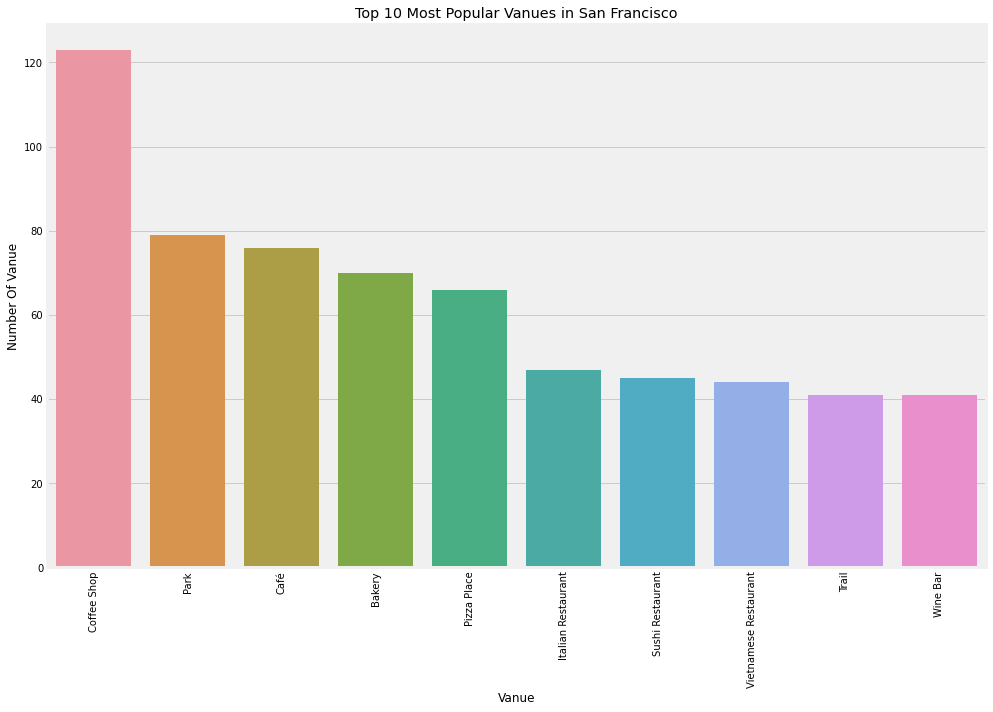

In [331]:
top_10_sf_venues = sf_venues['Venue Category'].value_counts().head(10)
utils.plot_barchart(pd.DataFrame(top_10_sf_venues).reset_index(), 'index', 'Venue Category', xlabel='Vanue', ylabel='Number Of Vanue', title='Top 10 Most Popular Vanues in San Francisco')

## 2.3 Methodology

In [625]:
# common categories
common_columns = list(set(la_venues['Venue Category']) & set(sf_venues['Venue Category']))

In [626]:
la_onehot = pd.get_dummies(la_venues['Venue Category'])[common_columns]
la_onehot['Neighborhood'] = la_venues['Neighborhood']
la_grouped = la_onehot.groupby('Neighborhood').mean().reset_index()
la_grouped.head()

,Neighborhood,Sandwich Place,Accessories Store,Electronics Store,Women's Store,Greek Restaurant,ATM,Athletics & Sports,Furniture / Home Store,Restaurant,...,Fried Chicken Joint,Pilates Studio,Beer Bar,Thrift / Vintage Store,Museum,Jazz Club,Tailor Shop,Italian Restaurant,Indie Movie Theater,Comedy Club
0,Atwater Village,0.016393,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.032787,...,0.00,0.016393,0.0,0.032787,0.0,0.0,0.0,0.016393,0.0,0.0
1,Beverly Crest,0.000000,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000000,...,0.00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2,Beverlywood,0.000000,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000000,...,0.00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
3,Boyle Heights,0.040000,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000000,...,0.08,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
4,Brentwood,0.025000,0.0,0.0,0.0,0.0,0.025,0.025,0.0,0.000000,...,0.00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.075000,0.0,0.0


In [627]:
sf_onehot = pd.get_dummies(sf_venues['Venue Category'])[common_columns]
sf_onehot['Neighborhood'] = sf_venues['Neighborhood']
sf_grouped = sf_onehot.groupby('Neighborhood').mean().reset_index()
sf_grouped.head()

,Neighborhood,Sandwich Place,Accessories Store,Electronics Store,Women's Store,Greek Restaurant,ATM,Athletics & Sports,Furniture / Home Store,Restaurant,...,Fried Chicken Joint,Pilates Studio,Beer Bar,Thrift / Vintage Store,Museum,Jazz Club,Tailor Shop,Italian Restaurant,Indie Movie Theater,Comedy Club
0,Bayview Hunters Point,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.00,0.000000,0.000000,0.00,0.0,0.0,0.000000,0.00,0.0
1,Bernal Heights,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.020000,...,0.000000,0.00,0.010000,0.000000,0.00,0.0,0.0,0.030000,0.00,0.0
2,Castro/Upper Market,0.010000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.01,0.000000,0.000000,0.01,0.0,0.0,0.010000,0.01,0.0
3,Chinatown,0.000000,0.010101,0.0,0.0,0.010101,0.0,0.0,0.0,0.020202,...,0.000000,0.00,0.010101,0.000000,0.00,0.0,0.0,0.050505,0.00,0.0
4,Excelsior,0.024096,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.036145,...,0.012048,0.00,0.000000,0.012048,0.00,0.0,0.0,0.000000,0.00,0.0


In [628]:
concatenated_df = pd.concat([la_grouped[['Neighborhood']+common_columns], sf_grouped[['Neighborhood']+common_columns]], ignore_index=True)
normalized_data = MinMaxScaler().fit_transform(concatenated_df.drop('Neighborhood', axis=1))
concatenated_df[common_columns] = pd.DataFrame(normalized_data, columns=common_columns)
concatenated_df

,Neighborhood,Sandwich Place,Accessories Store,Electronics Store,Women's Store,Greek Restaurant,ATM,Athletics & Sports,Furniture / Home Store,Restaurant,...,Fried Chicken Joint,Pilates Studio,Beer Bar,Thrift / Vintage Store,Museum,Jazz Club,Tailor Shop,Italian Restaurant,Indie Movie Theater,Comedy Club
0,Atwater Village,0.180328,0.000,0.0,0.0,0.0,0.000,0.000,0.00,0.491803,...,0.000,1.0,0.00,0.590164,0.0,0.0,0.0,0.213115,0.0,0.0
1,Beverly Crest,0.000000,0.000,0.0,0.0,0.0,0.000,0.000,0.00,0.000000,...,0.000,0.0,0.00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2,Beverlywood,0.000000,0.000,0.0,0.0,0.0,0.000,0.000,0.00,0.000000,...,0.000,0.0,0.00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
3,Boyle Heights,0.440000,0.000,0.0,0.0,0.0,0.000,0.000,0.00,0.000000,...,1.000,0.0,0.00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
4,Brentwood,0.275000,0.000,0.0,0.0,0.0,0.475,0.725,0.00,0.000000,...,0.000,0.0,0.00,0.000000,0.0,0.0,0.0,0.975000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,Tenderloin,0.220000,0.000,0.0,0.0,0.0,0.000,0.000,0.00,0.150000,...,0.000,0.0,0.84,0.000000,0.0,0.7,0.0,0.000000,0.0,0.0
85,Twin Peaks,0.000000,0.000,0.0,0.0,0.0,0.000,0.000,0.00,0.000000,...,0.000,0.0,0.00,0.000000,0.0,0.0,1.0,0.000000,0.0,0.0
86,Visitacion Valley,0.000000,0.000,0.0,0.0,0.0,0.000,0.000,0.00,0.000000,...,0.000,0.0,0.00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
87,West of Twin Peaks,0.000000,0.000,0.0,0.0,0.0,0.000,0.000,0.00,0.000000,...,0.000,0.0,0.00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0


# 3. *Clustering*

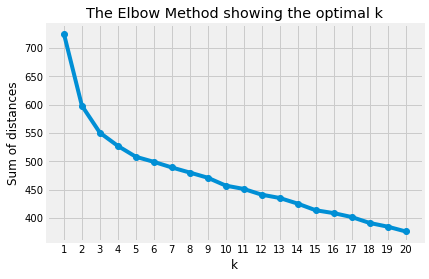

In [757]:
K = range(1, 21)
models = [KMeans(n_clusters=k, n_init=100).fit(concatenated_df.drop('Neighborhood', axis=1)) for k in K]
dist = [model.inertia_ for model in models]

plt.plot(K, dist, marker='o')
plt.xlabel('k')
plt.ylabel('Sum of distances')
plt.xticks(K)
plt.title('The Elbow Method showing the optimal k')
plt.show()

The Elbow Method doesn't clearly show optimal number of clusters. Let's build dendogram , as the second opinion.

In [758]:
X = concatenated_df.drop('Neighborhood', axis=1)

In [759]:
Z = hierarchy.linkage(X, 'ward', 'euclidean')

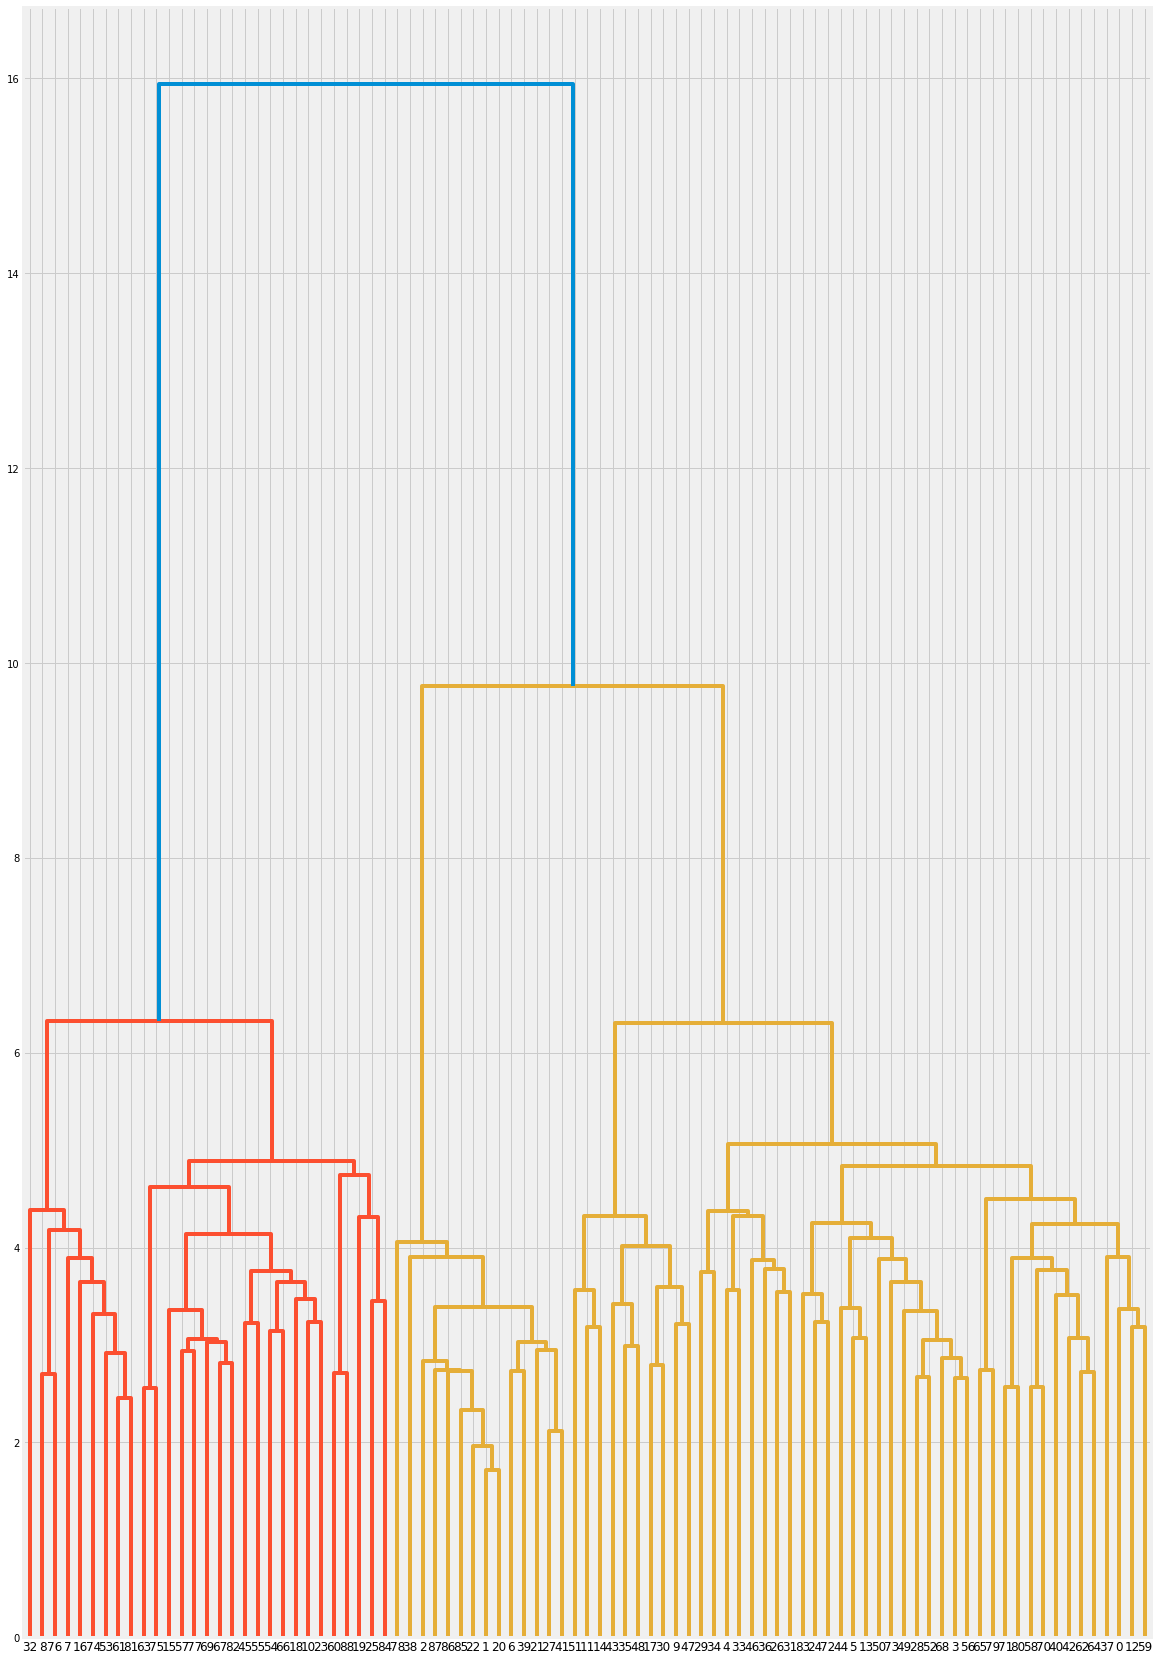

In [957]:
plt.figure(figsize=(18, 30))
dendro = hierarchy.dendrogram(Z, leaf_rotation=0, leaf_font_size=12)

Looks like optimal number of clusters is 5.

In [1029]:
K = 5
model = models[K-1]
concatenated_df['Cluster'] = model.labels_
concatenated_df.groupby('Cluster').size()

Cluster
0    14
1    11
2    12
3    19
4    33
dtype: int64

In [1030]:
la_clusters = concatenated_df.iloc[:la_grouped.shape[0], :]
la_clusters = la_clusters.merge(la_neighborhoods[['Neighborhood', 'Latitude', 'Longitude']], on='Neighborhood', how='left')
la_clusters.head()

,Neighborhood,Sandwich Place,Accessories Store,Electronics Store,Women's Store,Greek Restaurant,ATM,Athletics & Sports,Furniture / Home Store,Restaurant,...,Thrift / Vintage Store,Museum,Jazz Club,Tailor Shop,Italian Restaurant,Indie Movie Theater,Comedy Club,Cluster,Latitude,Longitude
0,Atwater Village,0.180328,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.491803,...,0.590164,0.0,0.0,0.0,0.213115,0.0,0.0,4,34.116398,-118.256464
1,Beverly Crest,0.000000,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0,34.101300,-118.416300
2,Beverlywood,0.000000,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0,34.045933,-118.394920
3,Boyle Heights,0.440000,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,4,34.052126,-118.204338
4,Brentwood,0.275000,0.0,0.0,0.0,0.0,0.475,0.725,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.975000,0.0,0.0,4,34.052140,-118.474070


In [1031]:
sf_clusters = concatenated_df.iloc[la_grouped.shape[0] :, :]
sf_clusters = sf_clusters.merge(sf_neighborhoods[['Neighborhood', 'Latitude', 'Longitude']], on='Neighborhood', how='left')
sf_clusters.head()

,Neighborhood,Sandwich Place,Accessories Store,Electronics Store,Women's Store,Greek Restaurant,ATM,Athletics & Sports,Furniture / Home Store,Restaurant,...,Thrift / Vintage Store,Museum,Jazz Club,Tailor Shop,Italian Restaurant,Indie Movie Theater,Comedy Club,Cluster,Latitude,Longitude
0,Bayview Hunters Point,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000,0.0,0.0,0.000000,0.000,0.0,4,37.730769,-122.382009
1,Bernal Heights,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.300000,...,0.000000,0.000,0.0,0.0,0.390000,0.000,0.0,1,37.740512,-122.416067
2,Castro/Upper Market,0.11000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.185,0.0,0.0,0.130000,0.285,0.0,3,37.762519,-122.436733
3,Chinatown,0.00000,0.277778,0.0,0.0,0.454545,0.0,0.0,0.0,0.303030,...,0.000000,0.000,0.0,0.0,0.656566,0.000,0.0,3,37.797113,-122.406529
4,Excelsior,0.26506,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.542169,...,0.216867,0.000,0.0,0.0,0.000000,0.000,0.0,4,37.720120,-122.434370


In [1032]:
cluster_colors = ['red', 'orange', 'blue', 'yellow', 'grey']

In [1033]:
utils.draw_neigborhoods_map((la_latitude, la_longitude),la_clusters, cluster_colors)

In [1034]:
utils.draw_neigborhoods_map((sf_latitude, sf_longitude),sf_clusters, cluster_colors)

# 4. *Descriptions*


# First Cluster

In [1182]:
def top_n_venues_for_cluster(df, cluster, top_n=10):
    cluste_df = df[df['Cluster'] == cluster]
    return utils.return_n_most_common_venues( cluste_df.drop(['Latitude', 'Longitude', 'Cluster'], axis=1), top_n) 


def average_n_venues_for_cluster(df, cluster, top_n=10):
    t = pd.DataFrame(df[df['Cluster'] == cluster].mean()).T
    t['Cluster'] = np.repeat(cluster, t.shape[0])
    t.insert(0,'Neighborhood', 0)
    return top_n_venues_for_cluster(t, cluster, top_n).drop('Neighborhood', axis=1)

Los Angeles

In [1183]:
l1 = top_n_venues_for_cluster(la_clusters, 0)
l1 = l1.merge(la_neighborhoods[['Neighborhood', 'CrimeRate', 'RentRate']], on='Neighborhood', how='left').sort_values('CrimeRate')
l1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,CrimeRate,RentRate
5,Lakeview Terrace,Garden,Food & Drink Shop,Park,Trail,Comedy Club,Filipino Restaurant,Health & Beauty Service,Wine Bar,German Restaurant,Sporting Goods Shop,0.235989,0.476460
0,Beverly Crest,Playground,Park,Trail,Comedy Club,Gastropub,Health & Beauty Service,Wine Bar,German Restaurant,Sporting Goods Shop,Tanning Salon,0.242924,0.774732
1,Beverlywood,Food Truck,Burrito Place,Boutique,Historic Site,Park,Women's Store,Filipino Restaurant,Taiwanese Restaurant,Health & Beauty Service,Wine Bar,0.253608,0.625745
9,Sylmar,Pizza Place,Business Service,Food,Mexican Restaurant,Park,Comedy Club,Food & Drink Shop,Bar,Burrito Place,Supermarket,0.278538,0.624255
6,Montecito Heights,Food,Lake,Donut Shop,Gas Station,Pizza Place,Park,Food & Drink Shop,Bar,Burrito Place,Supermarket,0.279288,0.444875
3,Hollywood Hills,Mountain,Trail,Park,Comedy Club,Health & Beauty Service,Wine Bar,German Restaurant,Sporting Goods Shop,Tanning Salon,Supermarket,0.565886,0.693683
8,South Park,Grocery Store,Taco Place,Shopping Mall,Video Store,Park,Mexican Restaurant,Health & Beauty Service,Wine Bar,German Restaurant,Filipino Restaurant,0.604873,0.920739
4,Hyde Park,Motel,Bookstore,Performing Arts Venue,Fast Food Restaurant,Taco Place,Grocery Store,Convenience Store,Chinese Restaurant,Food,Pizza Place,0.662231,0.533671
7,South Los Angeles,Light Rail Station,Intersection,Bus Stop,Fast Food Restaurant,American Restaurant,Shipping Store,Wings Joint,Seafood Restaurant,Tanning Salon,Supermarket,0.847235,0.523838
2,Central City,Liquor Store,Gas Station,Burger Joint,Breakfast Spot,Mexican Restaurant,Grocery Store,Park,German Restaurant,Wine Bar,Filipino Restaurant,0.955951,0.490465


San Francisco

In [1184]:
s1 = top_n_venues_for_cluster(sf_clusters, 0)
s1 = s1.merge(sf_neighborhoods[['Neighborhood', 'CrimeRate', 'RentRate']], on='Neighborhood', how='left').sort_values('CrimeRate')
s1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,CrimeRate,RentRate
0,Presidio,Tunnel,Museum,General Entertainment,Garden Center,Brewery,Plaza,Sporting Goods Shop,Gift Shop,Bowling Alley,Movie Theater,0.094787,0.880000
1,Twin Peaks,Tailor Shop,Monument / Landmark,Reservoir,Trail,Playground,Supermarket,Filipino Restaurant,Food & Drink Shop,Bar,Burrito Place,0.141232,0.773333
2,Visitacion Valley,Convenience Store,Garden,Pool,Vietnamese Restaurant,Coffee Shop,Park,Trail,Comedy Club,Food & Drink Shop,Wine Bar,0.346445,0.666667
3,West of Twin Peaks,Spa,Dumpling Restaurant,Monument / Landmark,Breakfast Spot,Sushi Restaurant,Bar,Vietnamese Restaurant,Convenience Store,Grocery Store,Café,0.604265,0.773333


Average top 10 venues categories in Los Angeles

In [1193]:
average_n_venues_for_cluster(la_clusters, 0)

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Park,Grocery Store,Food,Gas Station,Pizza Place,Fast Food Restaurant,Mexican Restaurant,Taco Place,Trail,Light Rail Station


Average crime and rent rates in Los Angeles

In [1186]:
l1[['CrimeRate', 'RentRate']].mean()

CrimeRate    0.492652
RentRate     0.610846
dtype: float64

Average top 10 venues categories in San Francisco

In [1187]:
average_n_venues_for_cluster(sf_clusters, 0)

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Monument / Landmark,Convenience Store,Vietnamese Restaurant,Café,Dumpling Restaurant,Pool,General Entertainment,Reservoir,Tunnel,Spa


Average crime and rent rates in San Francisco

In [1188]:
s1[['CrimeRate', 'RentRate']].mean()

CrimeRate    0.296682
RentRate     0.773333
dtype: float64

# Second Cluster

Los Angeles

In [1155]:
l2 = top_n_venues_for_cluster(la_clusters, 1)
l2 = l2.merge(la_neighborhoods[['Neighborhood', 'CrimeRate', 'RentRate']], on='Neighborhood', how='left').sort_values('CrimeRate')
l2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,CrimeRate,RentRate
2,Glassell Park,Pharmacy,Filipino Restaurant,Café,Bakery,Restaurant,Performing Arts Venue,Sandwich Place,Shipping Store,Bar,Pool,0.332334,0.594756
0,Chatsworth,Supermarket,Beer Bar,Flower Shop,Rock Club,BBQ Joint,Creperie,Hotel,Sushi Restaurant,Spa,Mexican Restaurant,0.333083,0.660012
3,Pico-Robertson,Deli / Bodega,Salon / Barbershop,Alternative Healer,Spiritual Center,Arcade,Jewelry Store,French Restaurant,Sushi Restaurant,Recreation Center,Thai Restaurant,0.419869,0.717521
1,Chinatown,Chinese Restaurant,Jazz Club,Dim Sum Restaurant,Plaza,Bakery,Record Shop,Recreation Center,Brewery,Tea Room,Vietnamese Restaurant,0.534021,0.670739


San Francisco

In [1156]:
s2 = top_n_venues_for_cluster(sf_clusters, 1)
s2 = s2.merge(sf_neighborhoods[['Neighborhood', 'CrimeRate', 'RentRate']], on='Neighborhood', how='left').sort_values('CrimeRate')
s2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,CrimeRate,RentRate
5,Seacliff,Southern / Soul Food Restaurant,Flea Market,Sushi Restaurant,Garden Center,Tea Room,Café,Korean Restaurant,Restaurant,Athletics & Sports,BBQ Joint,0.037915,0.800000
4,Portola,Library,Recreation Center,Bubble Tea Shop,Chinese Restaurant,Brewery,Dim Sum Restaurant,Tea Room,Vietnamese Restaurant,Bakery,BBQ Joint,0.332701,0.613333
2,Japantown,Udon Restaurant,Tea Room,Bakery,Ice Cream Shop,Jazz Club,Ramen Restaurant,Escape Room,Cosmetics Shop,Creperie,Pub,0.336493,0.680000
1,Inner Richmond,Bakery,Sushi Restaurant,Wine Shop,Chinese Restaurant,Southern / Soul Food Restaurant,Korean Restaurant,Japanese Restaurant,Bubble Tea Shop,Farmers Market,Dim Sum Restaurant,0.408531,0.680000
0,Bernal Heights,Butcher,Cocktail Bar,Brewery,Gourmet Shop,Bakery,Southern / Soul Food Restaurant,Flea Market,Record Shop,Indian Restaurant,Latin American Restaurant,0.472038,0.826667
3,Outer Richmond,Tiki Bar,Sporting Goods Shop,Music Store,Chinese Restaurant,Flower Shop,Café,Record Shop,Bakery,Noodle House,Dim Sum Restaurant,0.634597,0.666667
6,Sunset/Parkside,Baseball Field,Taiwanese Restaurant,Bar,Market,Korean Restaurant,Chinese Restaurant,Dumpling Restaurant,Bakery,Pharmacy,Italian Restaurant,0.764929,0.693333


Average top 10 venues categories in Los Angeles

In [1157]:
average_n_venues_for_cluster(la_clusters, 1)

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bakery,Sushi Restaurant,Beer Bar,Recreation Center,Filipino Restaurant,BBQ Joint,Café,Chinese Restaurant,Bar,Sandwich Place


Average crime and rent rates in Los Angeles

In [1158]:
l2[['CrimeRate', 'RentRate']].mean()

CrimeRate    0.404827
RentRate     0.660757
dtype: float64

Average top 10 venues categories in San Francisco

In [1159]:
average_n_venues_for_cluster(sf_clusters, 1)

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bakery,Chinese Restaurant,Tea Room,Korean Restaurant,Bubble Tea Shop,Southern / Soul Food Restaurant,BBQ Joint,Sushi Restaurant,Flower Shop,Vietnamese Restaurant


Average crime and rent rates in San Francisco

In [1160]:
s2[['CrimeRate', 'RentRate']].mean()

CrimeRate    0.426743
RentRate     0.708571
dtype: float64

# Third Cluster

Los Angeles

In [1127]:
l3 = top_n_venues_for_cluster(la_clusters, 2)
l3 = l3.merge(la_neighborhoods[['Neighborhood', 'CrimeRate', 'RentRate']], on='Neighborhood', how='left').sort_values('CrimeRate')
l3

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,CrimeRate,RentRate
1,Eagle Rock,Wine Shop,Board Shop,Bubble Tea Shop,Farmers Market,American Restaurant,Ramen Restaurant,Music Venue,Mobile Phone Shop,Dessert Shop,Pharmacy,0.291284,0.595650
3,Granada Hills,Smoke Shop,Cupcake Shop,Middle Eastern Restaurant,Discount Store,Pharmacy,Poke Place,Supermarket,Bank,Furniture / Home Store,Salad Place,0.327085,0.655840
6,Reseda,Arts & Crafts Store,Greek Restaurant,Pharmacy,Noodle House,Thrift / Vintage Store,Vietnamese Restaurant,Discount Store,Music Venue,Supermarket,Gift Shop,0.328772,0.556317
2,Encino,Yoga Studio,Miscellaneous Shop,Steakhouse,Supplement Shop,Board Shop,Pet Store,ATM,Health & Beauty Service,Japanese Restaurant,Sushi Restaurant,0.348079,0.733015
5,Northridge,Comic Shop,Smoke Shop,Middle Eastern Restaurant,Hot Dog Joint,Burger Joint,Chinese Restaurant,Dessert Shop,Discount Store,Mobile Phone Shop,BBQ Joint,0.419306,0.637068
7,Valley Village,Cuban Restaurant,Discount Store,Music Venue,Mobile Phone Shop,Dessert Shop,Eastern European Restaurant,Supermarket,Arts & Crafts Store,Cosmetics Shop,Sushi Restaurant,0.425117,0.699642
11,Woodland Hills,Supplement Shop,Bagel Shop,Mediterranean Restaurant,Ice Cream Shop,Sushi Restaurant,Smoke Shop,Indian Restaurant,Spa,Health & Beauty Service,Sports Bar,0.444799,0.706794
4,North Hollywood,Theater,Greek Restaurant,Smoke Shop,Hardware Store,Big Box Store,Sports Bar,Farmers Market,Hawaiian Restaurant,Gastropub,Music Venue,0.519025,0.766389
8,Van Nuys,Hot Dog Joint,Mobile Phone Shop,Cuban Restaurant,BBQ Joint,Furniture / Home Store,Convenience Store,Chinese Restaurant,Sandwich Place,Latin American Restaurant,Shoe Store,0.520150,0.592074
10,Westlake,Clothing Store,Hardware Store,Music Venue,Discount Store,Bakery,Pharmacy,Bagel Shop,Metro Station,Supermarket,Cocktail Bar,0.531584,0.606079


Average top 10 venues categories in Los Angeles

In [1161]:
average_n_venues_for_cluster(la_clusters, 2)

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Mobile Phone Shop,Discount Store,Pharmacy,Sandwich Place,Supermarket,Bank,Smoke Shop,Music Venue,Pet Store,Chinese Restaurant


Average crime and rent rates in Los Angeles

In [1162]:
l3[['CrimeRate', 'RentRate']].mean()

CrimeRate    0.489160
RentRate     0.673148
dtype: float64

# Fourth Cluster

Los Angeles

In [1163]:
l4 = top_n_venues_for_cluster(la_clusters, 3)
l4 = l4.merge(la_neighborhoods[['Neighborhood', 'CrimeRate', 'RentRate']], on='Neighborhood', how='left').sort_values('CrimeRate')
l4

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,CrimeRate,RentRate
2,Highland Park,Spanish Restaurant,Women's Store,Bakery,Record Shop,Concert Hall,Clothing Store,Mediterranean Restaurant,Organic Grocery,Farmers Market,Sandwich Place,0.302718,0.552443
4,Los Feliz,Butcher,Mediterranean Restaurant,Health Food Store,Italian Restaurant,Wine Shop,Juice Bar,Dive Bar,Board Shop,Electronics Store,Nail Salon,0.416307,0.674315
5,Mid City,Candy Store,Plaza,Opera House,Udon Restaurant,Concert Hall,Ramen Restaurant,Music Venue,Sushi Restaurant,Art Museum,Jazz Club,0.498594,0.604589
1,Financial District,Hotel Bar,Roof Deck,Brewery,Hotel,Miscellaneous Shop,Sushi Restaurant,New American Restaurant,Cycle Studio,Theater,Vegetarian / Vegan Restaurant,0.599813,0.955304
6,Venice,German Restaurant,Kitchen Supply Store,Men's Store,Clothing Store,Garden Center,Vegetarian / Vegan Restaurant,Women's Store,Cosmetics Shop,Juice Bar,Ice Cream Shop,0.860544,1.000000
3,Hollywood,Comedy Club,Lingerie Store,Lounge,Nightclub,Beer Garden,Office,Salad Place,Vegetarian / Vegan Restaurant,Jazz Club,Indie Theater,1.000000,0.785757
0,Downtown,Gastropub,Coworking Space,Bar,Tiki Bar,Escape Room,Athletics & Sports,Beer Store,Southern / Soul Food Restaurant,Flea Market,Clothing Store,2.688285,0.732718


San Francisco

In [1164]:
s4 = top_n_venues_for_cluster(sf_clusters, 3)
s4 = s4.merge(sf_neighborhoods[['Neighborhood', 'CrimeRate', 'RentRate']], on='Neighborhood', how='left').sort_values('CrimeRate')
s4

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,CrimeRate,RentRate
8,Potrero Hill,Office,Wine Bar,Art Museum,Brewery,Gift Shop,Indie Theater,Southern / Soul Food Restaurant,Cheese Shop,Dog Run,Cocktail Bar,0.472986,0.893333
7,Pacific Heights,Kitchen Supply Store,Gift Shop,Ice Cream Shop,Bakery,Women's Store,Tea Room,Escape Room,Ramen Restaurant,Cosmetics Shop,Beer Store,0.533649,0.986667
1,Chinatown,Szechuan Restaurant,Men's Store,Bakery,Argentinian Restaurant,Italian Restaurant,New American Restaurant,Dive Bar,Wine Bar,Cocktail Bar,Deli / Bodega,0.555924,0.880000
4,Marina,Beer Garden,Kitchen Supply Store,Gym / Fitness Center,Wine Bar,Spanish Restaurant,Italian Restaurant,Electronics Store,Cycle Studio,Vegetarian / Vegan Restaurant,Salad Place,0.724645,0.925333
3,Hayes Valley,Comic Shop,Beer Garden,Cocktail Bar,Record Shop,German Restaurant,Butcher,Wine Bar,Ice Cream Shop,Dive Bar,BBQ Joint,0.836493,0.984000
0,Castro/Upper Market,Beer Garden,Candy Store,Gay Bar,Spanish Restaurant,Pilates Studio,New American Restaurant,Dog Run,Nail Salon,Concert Hall,Wine Bar,0.883412,0.906667
6,Nob Hill,Hotel Bar,Office,Beer Bar,Cocktail Bar,Wine Bar,Italian Restaurant,Massage Studio,Spa,Gym / Fitness Center,Hotel,0.899052,0.853333
11,Western Addition,Wine Bar,Beer Garden,German Restaurant,Concert Hall,Opera House,Cocktail Bar,Butcher,Tiki Bar,Jazz Club,French Restaurant,1.000000,0.880000
9,South Of Market,Marijuana Dispensary,Coworking Space,Wine Bar,Spanish Restaurant,Bakery,Electronics Store,Hotel Bar,Arts & Crafts Store,Art Gallery,Jewelry Store,2.547867,0.973333
2,Financial District/South Beach,Roof Deck,Office,Dim Sum Restaurant,Spanish Restaurant,Argentinian Restaurant,Mediterranean Restaurant,Cycle Studio,Cheese Shop,Wine Bar,Men's Store,2.799052,0.946667


Average top 10 venues categories in Los Angeles

In [1165]:
average_n_venues_for_cluster(la_clusters, 3)

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bar,Clothing Store,Mediterranean Restaurant,Juice Bar,Gastropub,Ice Cream Shop,Italian Restaurant,Concert Hall,Coffee Shop,Vegetarian / Vegan Restaurant


Average crime and rent rates in Los Angeles

In [1166]:
l4[['CrimeRate', 'RentRate']].mean()

CrimeRate    0.909466
RentRate     0.757875
dtype: float64

Average top 10 venues categories in San Francisco

In [1167]:
average_n_venues_for_cluster(sf_clusters, 3)

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Wine Bar,Cocktail Bar,Bakery,Beer Garden,Gym / Fitness Center,Office,Coffee Shop,Ice Cream Shop,Italian Restaurant,French Restaurant


Average crime and rent rates in San Francisco

In [1168]:
s4[['CrimeRate', 'RentRate']].mean()

CrimeRate    1.479147
RentRate     0.902444
dtype: float64

# Fifth Cluster

In [1169]:
l5 = top_n_venues_for_cluster(la_clusters, 4)
l5 = l5.merge(la_neighborhoods[['Neighborhood', 'CrimeRate', 'RentRate']], on='Neighborhood', how='left').sort_values('CrimeRate')
l5

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,CrimeRate,RentRate
17,Westwood,Residential Building (Apartment / Condo),Bank,Bus Station,New American Restaurant,Hotel,Italian Restaurant,Coffee Shop,Food Truck,Fast Food Restaurant,German Restaurant,0.235239,1.166567
6,Mar Vista,Gourmet Shop,Martial Arts School,Noodle House,Music Store,Japanese Restaurant,Market,Taiwanese Restaurant,Accessories Store,Furniture / Home Store,Indian Restaurant,0.243299,0.689809
5,El Sereno,Brazilian Restaurant,ATM,South American Restaurant,Seafood Restaurant,Thrift / Vintage Store,Restaurant,Bank,Liquor Store,Mexican Restaurant,Grocery Store,0.267666,0.536353
2,Brentwood,Juice Bar,Track,Shoe Store,Gym / Fitness Center,Italian Restaurant,Farmers Market,Wine Shop,Pharmacy,Athletics & Sports,Massage Studio,0.313027,0.847735
18,Winnetka,Frozen Yogurt Shop,Department Store,Diner,Bowling Alley,Toy / Game Store,Hobby Shop,Hot Dog Joint,Restaurant,Hotel,Burger Joint,0.319213,0.623063
9,Palms,Organic Grocery,Hawaiian Restaurant,Sports Bar,Farmers Market,Ramen Restaurant,BBQ Joint,Italian Restaurant,Vegetarian / Vegan Restaurant,Sandwich Place,Grocery Store,0.329709,0.907926
10,Playa Del Rey,Athletics & Sports,Speakeasy,Optical Shop,Massage Studio,Gym / Fitness Center,Dog Run,Indian Restaurant,Mediterranean Restaurant,Deli / Bodega,Baseball Field,0.342643,0.728546
8,North Hills,Sculpture Garden,Golf Course,Financial or Legal Service,Dance Studio,Coffee Shop,Asian Restaurant,Seafood Restaurant,Health & Beauty Service,Wine Bar,German Restaurant,0.366448,0.454112
16,West Los Angeles,Sake Bar,Middle Eastern Restaurant,Beer Store,Indie Movie Theater,Szechuan Restaurant,Sushi Restaurant,Japanese Restaurant,Garden Center,Farmers Market,Gastropub,0.418932,0.828963
11,Playa Vista,Dog Run,Cycle Studio,Electronics Store,Pub,Nail Salon,Recreation Center,Hardware Store,Hawaiian Restaurant,Farmers Market,Gastropub,0.422868,0.856973


In [1170]:
s5 = top_n_venues_for_cluster(sf_clusters, 4)
s5 = s5.merge(sf_neighborhoods[['Neighborhood', 'CrimeRate', 'RentRate']], on='Neighborhood', how='left').sort_values('CrimeRate')
s5

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,CrimeRate,RentRate
2,Glen Park,Cheese Shop,Alternative Healer,Library,Dim Sum Restaurant,Dive Bar,Dog Run,Gift Shop,Grocery Store,Furniture / Home Store,Coffee Shop,0.142180,0.786667
12,Presidio Heights,Furniture / Home Store,Health Food Store,Health & Beauty Service,Cosmetics Shop,Miscellaneous Shop,Supplement Shop,Pub,Wine Bar,Hotel Bar,Baby Store,0.155450,0.853333
8,Noe Valley,Gift Shop,Wine Shop,Cheese Shop,Pub,Bakery,Greek Restaurant,Library,Bookstore,Gourmet Shop,Health & Beauty Service,0.276303,0.826667
10,Oceanview/Merced/Ingleside,Thai Restaurant,Intersection,Liquor Store,Light Rail Station,Japanese Restaurant,Grocery Store,Café,Coffee Shop,Playground,Park,0.286256,0.613333
6,Lone Mountain/USF,Health & Beauty Service,Women's Store,Supplement Shop,Café,Pub,Wine Bar,Furniture / Home Store,Salon / Barbershop,Cosmetics Shop,Coffee Shop,0.317536,0.720000
4,Inner Sunset,Salad Place,Vegetarian / Vegan Restaurant,Sandwich Place,Cosmetics Shop,Ice Cream Shop,Middle Eastern Restaurant,Tennis Court,Bus Stop,Sushi Restaurant,Trail,0.337441,0.730667
5,Lakeshore,Sandwich Place,Sushi Restaurant,Tennis Court,American Restaurant,Gym,Lake,Pizza Place,Golf Course,Park,Filipino Restaurant,0.373934,0.720000
11,Outer Mission,Dive Bar,Metro Station,Pedestrian Plaza,Poke Place,BBQ Joint,Bubble Tea Shop,Grocery Store,Dessert Shop,Baseball Field,Bank,0.407583,0.600000
1,Excelsior,Latin American Restaurant,Restaurant,Pharmacy,Bakery,Basketball Court,Bubble Tea Shop,Gastropub,Chinese Restaurant,Mobile Phone Shop,Deli / Bodega,0.465877,0.600000
7,Mission Bay,Beer Garden,Tanning Salon,New American Restaurant,Coffee Shop,Southern / Soul Food Restaurant,Pub,Wine Bar,Food Truck,Basketball Court,Brewery,0.468720,1.000000


Average top 10 venues categories in Los Angeles

In [1198]:
average_n_venues_for_cluster(la_clusters, 4)

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Coffee Shop,Gym / Fitness Center,Farmers Market,Sandwich Place,Pharmacy,Italian Restaurant,Bank,Grocery Store,Furniture / Home Store,Burger Joint


Average crime and rent rates in Los Angeles

In [1196]:
l5[['CrimeRate', 'RentRate']].mean()

CrimeRate    0.407863
RentRate     0.712941
dtype: float64

Average top 10 venues categories in San Francisco

In [1199]:
average_n_venues_for_cluster(sf_clusters, 4)

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Coffee Shop,Cosmetics Shop,Sandwich Place,Bakery,Sushi Restaurant,American Restaurant,Furniture / Home Store,Café,Grocery Store,Wine Bar


Average crime and rent rates in San Francisco

In [1174]:
s5[['CrimeRate', 'RentRate']].mean()

CrimeRate    0.505924
RentRate     0.770286
dtype: float64

# Neighborhood Similarity Based on Top 10 Most Popular Venues Within Cluster .
# 0 - 0% Matched , 100 - 100% Matched

In [1142]:
def score_map(n_a, n_b):
    score_map = {
        0 : 10,
        1 : 9,
        2 : 8,
        3 : 7,
        4 : 6,
        5 : 5,
        6 : 4,
        7 : 3,
        8 : 2,
        9 : 1

    }
    df = pd.DataFrame(columns=list(n_a['Neighborhood']), index=list(n_b['Neighborhood']))
    for row_a in n_a.itertuples():
        venues_a = row_a[2:-2]
        neighbor_a = row_a[1]
        for row_b in n_b.itertuples():
            total_score = 0
            venues_b = row_b[2:-2]
            neighbor_b = row_b[1]

            common_venues = set(venues_a) & set(venues_b)
            for cv in common_venues:
                index = abs(venues_a.index(cv) - venues_b.index(cv))
                total_score += score_map[index]
            df.loc[neighbor_b, neighbor_a] = total_score
    for col in df.columns:
        df[col] = pd.to_numeric(df[col])
    return df

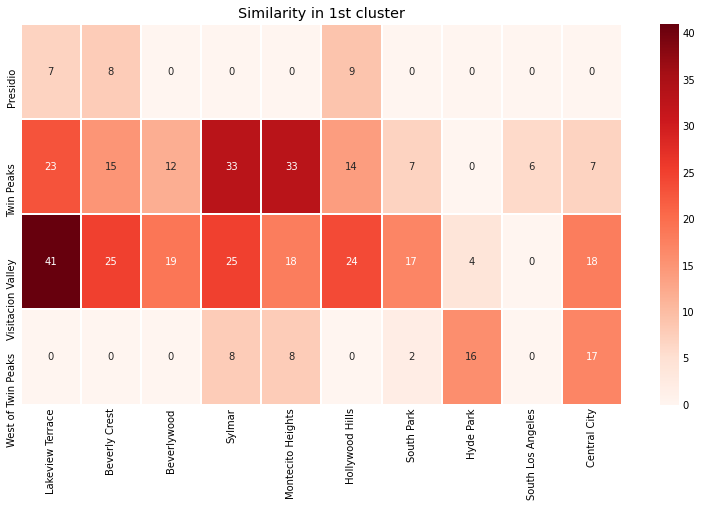

In [1143]:
fig, ax = plt.subplots(figsize = (12, 7))
sns.heatmap(score_map(l1, s1), cmap ='Reds', linewidths = 1, annot = True, ax=ax)
ax.set_title('Similarity in 1st cluster')
plt.show()

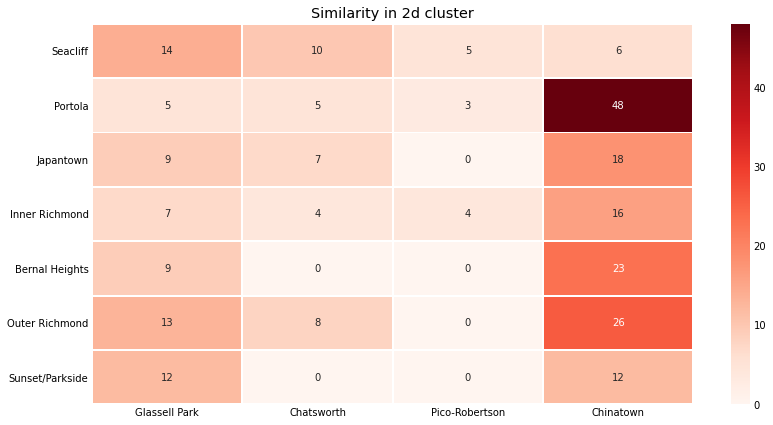

In [1144]:
fig, ax = plt.subplots(figsize = (12, 7))
sns.heatmap(score_map(l2, s2), cmap ='Reds', linewidths = 1, annot = True, ax=ax)
ax.set_title('Similarity in 2d cluster')
plt.show()

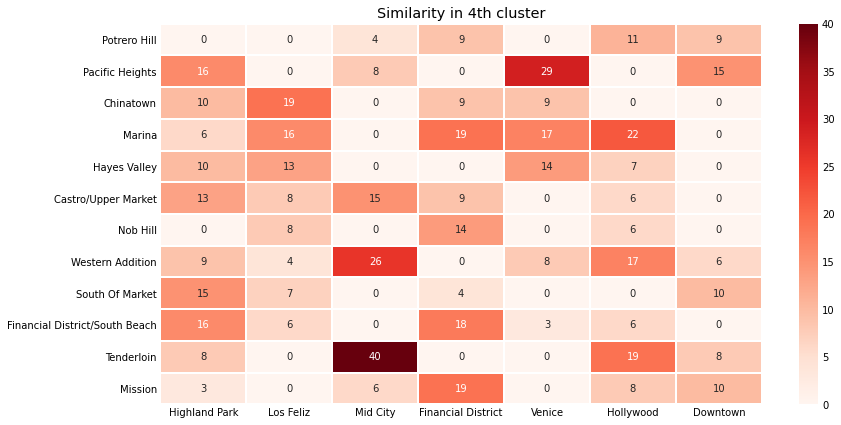

In [1145]:
fig, ax = plt.subplots(figsize = (12, 7))
sns.heatmap(score_map(l4, s4), cmap ='Reds', linewidths = 1, annot = True, ax=ax)
ax.set_title('Similarity in 4th cluster')
plt.show()

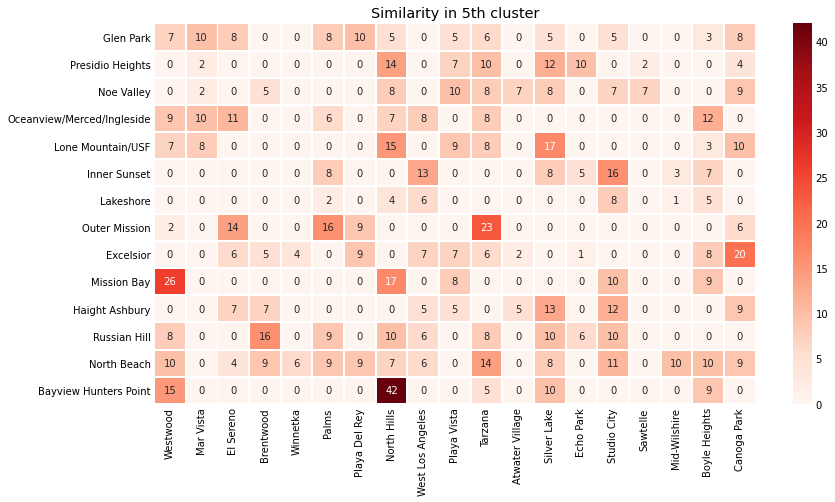

In [1146]:
fig, ax = plt.subplots(figsize = (12, 7))
sns.heatmap(score_map(l5, s5), cmap ='Reds', linewidths = 1, annot = True, ax=ax)
ax.set_title('Similarity in 5th cluster')
plt.show()